In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions.independent import Independent
class AgentDecoder(nn.Module):
  def __init__(self, horizon, seed, bound):
    super(AgentDecoder, self).__init__()

    self.dec_rnn = nn.LSTM(6, 100, 2)
    self.dec_linear = nn.Linear(100, 10)
    self.relu = nn.LeakyReLU()
      
    self.decoder_mu = nn.Linear(10, 2)
    self.decoder_log_sigma = nn.Linear(10, 2)

  def decoder(self, decoder_input_n):
    h, _ = self.dec_rnn(decoder_input_n)
    h = self.relu(self.dec_linear(h))
    # h = self.dec(decoder_input_n)
    mu = self.decoder_mu(h)
    log_sigma = self.decoder_log_sigma(h)
    return mu, log_sigma
  
  def decoderLosses(self, log_decoder):
    
    decoder_loss = -torch.mean(log_decoder)
    return  decoder_loss 

  def forward(self, decoder_input_n, source_action):
    decoder_mu, decoder_log_sigma = self.decoder(decoder_input_n)
    decoder_dist = Independent(Normal(decoder_mu, torch.exp(decoder_log_sigma)), 1)
    log_decoder = decoder_dist.log_prob(source_action)
    return decoder_mu, decoder_log_sigma, log_decoder

class AgentEmp(nn.Module):
  def __init__(self, horizon, seed, bound):
    super(AgentEmp, self).__init__()
    self.emp_rnn = nn.LSTM(2, 50, 2)
    self.emp_l1 = nn.Linear(50, 100)
    self.emp_l2 = nn.Linear(100, 1)
    self.relu = nn.LeakyReLU()

  def forward(self, current_state):
      h, _ = self.emp_rnn(current_state)
      h = self.relu(self.emp_l1(h))
      return self.emp_l2(h)


class AgentSource(nn.Module):
    def __init__(self, horizon, seed, bound):
        super(AgentSource, self).__init__()
        
        self.initializer = nn.init.xavier_normal_
       
        self.agent_rnn = nn.LSTM(4, 100, 2)
        self.agent_linear = nn.Linear(100, 10)
        self.relu = nn.LeakyReLU()
        
        self.src_mu = nn.Linear(10, 2)
        self.src_log_sigma = nn.Linear(10, 2)
    
    def source(self, source_input_n):
        h,_ = self.agent_rnn(source_input_n)
        h = self.relu(self.agent_linear(h))
        log_sigma = self.src_log_sigma(h)
        mu = self.src_mu(h)
        return mu, log_sigma
    
    def sourceDistribution(self, source_action, src_mu, src_log_sigma):
      
      src_dist = Independent(Normal(src_mu, torch.exp(src_log_sigma)), 1)
      log_src = src_dist.log_prob(source_action)
      return log_src
        
    def forward(self, source_input_n):
      src_mu, src_log_sigma = self.source(source_input_n)
      return src_log_sigma, src_mu

    def squaredLoss(self, beta, log_decoder, source_action, source_input_n, emp):
        src_mu, src_log_sigma = self.forward(source_input_n)
        log_src = self.sourceDistribution(source_action, src_mu, src_log_sigma)
        # print(src_mu, src_log_sigma, log_src)
        squared_loss = torch.mean(torch.square(beta * log_decoder - emp - log_src))
        return  squared_loss


In [9]:

import numpy as np

class square_env:
    def __init__(self,duration,radius,dimension):
        self.R = radius
        self.agent_dim = radius 
        self.dimension = dimension 
        self.eps = radius/100
        self.lower_limit, self.upper_limit = self.agent_dim+self.eps, self.dimension-self.agent_dim-self.eps
        print(self.lower_limit, self.upper_limit)
        self.iter = 0
        self.duration = duration 
        self.state_seq = np.zeros((self.duration,2))
        self.obstacles = np.array([[xObst, 1] for xObst in range(1, 6)])
                
    def random_initialisation(self):
            
        self.state_seq[self.iter][0] = np.random.uniform(self.lower_limit, self.upper_limit)
        self.state_seq[self.iter][1] = np.random.uniform(self.lower_limit, self.upper_limit)
        
        self.iter = 1
        
    def boundary_conditions(self):
        
        cond_X = not (self.state_seq[self.iter][0] >= self.lower_limit)*(self.state_seq[self.iter][0] <= self.upper_limit)
        cond_Y = not (self.state_seq[self.iter][1] >= self.lower_limit)*(self.state_seq[self.iter][1] <= self.upper_limit)
        if cond_X*cond_Y:
          return cond_X*cond_Y
        
        obs = bool(( True if int(self.state_seq[self.iter][0]) in self.obstacles[:,0] else False)*( True if int(self.state_seq[self.iter][1]) in self.obstacles[:,1] else False))
        # print(obs, cond_X*cond_Y)
        return obs
            
    def step(self, action):
                
        self.state_seq[self.iter] = self.state_seq[self.iter-1] + action
        if self.boundary_conditions():
            self.state_seq[self.iter] -= action
        # print(self.state_seq[self.iter], self.state_seq[self.iter-1], action)           
        self.iter += 1
        if self.iter > self.duration:
            raise Exception("Game over!") 
            
    def env_response(self,actions,horizon):
        for i in range(1,horizon):
            self.step(actions[i])
        # print(self.state_seq)
        
    def reset(self):
        self.state_seq = np.zeros((self.duration,2))
        self.iter = 0
        

In [10]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


In [11]:
!mkdir weights

mkdir: cannot create directory ‘weights’: File exists


In [14]:
import seaborn as sns

def heatmap(emp,env,num_image, res=1):
    plt.clf()
    
    R, D = env.R, env.dimension
    xy = np.mgrid[R:int(D)-R:res, R:int(D)-R:res].reshape(2,-1).T
    L = int((D-2*R)/res)

    mu = env.dimension/2.0 - R 
    sigma = ((2*mu)**2)/12
    xy_ = (xy - mu)/sigma
    
    values = emp(torch.FloatTensor(xy_)).detach().numpy()
    
    val = values.reshape(L,L)
    sns.heatmap(val[1:L,1:L],xticklabels=False,\
                yticklabels=False,cmap="YlGnBu", cbar=False)
    plt.savefig("plots/" + str(num_image)+".png")

In [ ]:

import matplotlib.pyplot as plt
import numpy as np
import copy

# define training parameters:
horizon = 2
seed = 42
bound = 0.5
iters = 100000
batch_size = 200
lr = 0.01
R = 0.0

# define environment:
env = square_env(duration=horizon,radius=R,dimension=10)

ADec = AgentDecoder(horizon,seed,bound)
ASrc = AgentSource(horizon,seed,bound)
AEmp = AgentEmp(horizon,seed,bound)
decoder_optimizer = optim.Adagrad(ADec.parameters(), lr=0.01)
# src_slow_optimizer = optim.Adagrad(ASrc.parameters() , lr=0.0005)
src_slow_optimizer = optim.Adagrad([
                {'params': ASrc.parameters()},
                {'params': AEmp.parameters(), 'lr': 5e-3}
            ], lr=5e-3)

loss_src = []
loss_dec = []
def main():
    # betas = 
    beta = 1e-2
    ## define inverse probability:
    inverse_prob = 1./np.array([min(0.01 + i/iters,1) for i in range(iters)])

    ### initialise the variables:

    for count in range(iters):
        env.reset()
        env.random_initialisation()

        mini_batch = np.zeros((batch_size*horizon,6))
        action_batch = np.zeros((batch_size*horizon,2))
        
        mu = env.dimension/2.0 - R 
        sigma = ((2*mu)**2)/12 
        for i in range(batch_size):

            env.iter = 0

            if np.random.rand() > 1/inverse_prob[count]:
                actions = np.random.normal(0,bound,size = (horizon,2))

                # net_actions = np.cumsum(actions,0)

            else:
                state = (env.state_seq[env.iter]-mu)/sigma
                actions = np.zeros((horizon,2))

                # net_actions = np.zeros((horizon,2))

                for i in range(1,horizon):

                    AS_n = np.concatenate((actions[i-1],state))
                    with torch.no_grad():
                      src_log_sigma, src_mu = ASrc(torch.FloatTensor(AS_n.reshape((1,4))))
                    actions[i] = np.random.normal(src_mu.clone().detach().numpy(),np.exp(src_log_sigma.clone().detach().numpy())) 
                      # net_actions[i] = actions[i] + net_actions[i-1]
                
            # print(actions)
            env.iter += 1 
            env.env_response(actions,horizon)

            ss_ = np.concatenate((env.state_seq[env.iter-horizon],env.state_seq[env.iter-1])).reshape((1,4))
            S = np.repeat(ss_,horizon,axis=0)
            # print("S", S, env.state_seq, env.iter-horizon, env.iter-1, env.iter)
            # print("action", actions)
        
            axx_ =  np.concatenate((actions,S),axis=1)

            mini_batch[horizon*i:horizon*(i+1)] = axx_
            action_batch[horizon*i:horizon*(i+1)] = actions
            # print("mini_batch[horizon*i:horizon*(i+1)]", mini_batch[horizon*i:horizon*(i+1)])

        mini_batch[:,2:6] = (mini_batch[:,2:6] - mu)/sigma
       
        decoder_mu, decoder_log_sigma, log_decoder = ADec(torch.FloatTensor(mini_batch), torch.FloatTensor(action_batch))
        
        decoderLoss = ADec.decoderLosses(log_decoder)
        log_decoder_clone = copy.deepcopy(log_decoder.clone().detach().numpy())
        decoderLoss_plot = copy.deepcopy(decoderLoss.clone().detach().numpy())
        loss_dec.append(decoderLoss_plot)

        
        decoder_optimizer.zero_grad()
        decoderLoss.backward()
        decoder_optimizer.step()

        emp = AEmp(torch.FloatTensor(mini_batch[:,2:4]))
        src_slow_optimizer.zero_grad()
        
        squaredLoss = ASrc.squaredLoss(beta, torch.FloatTensor(log_decoder_clone), torch.FloatTensor(action_batch), torch.FloatTensor(mini_batch[:,0:4]), emp)
        squaredLoss_plot = copy.deepcopy(squaredLoss.clone().detach().numpy())
        loss_src.append(squaredLoss_plot)

        squaredLoss.backward()
        src_slow_optimizer.step()
        if count % 500 == 0:
            print(count)
            heatmap(AEmp,env,count)

main()


In [ ]:
heatmap(AEmp,env,"count")


In [ ]:
def plot_kernels(tensor, num_cols=2):
    plt.clf()
   
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
   
    plt.imshow(tensor)
    plt.show()
    
    


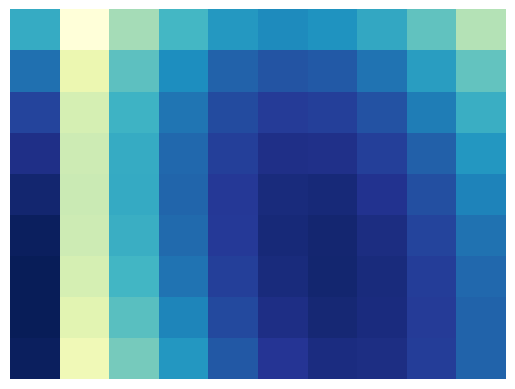

In [12]:
# import seaborn as sns

def heatmap(emp,env,num_image, res=1):
    plt.clf()
    
    R, D = env.R, env.dimension
    xy = np.mgrid[R:int(D)-R:res, R:int(D)-R:res].reshape(2,-1).T
    L = int((D-2*R)/res)
    # print(xy)

    mu = env.dimension/2.0 - R 
    sigma = ((2*mu)**2)/12
    xy_ = (xy - mu)/sigma
    
    values = emp(torch.FloatTensor(xy_)).detach().numpy()
    # print(values)
    # print(np.concatenate((xy,values),axis=1))
    val = values.reshape(L,L)
    sns.heatmap(val[1:L,0:L],xticklabels=False,
                yticklabels=False,cmap="YlGnBu", cbar=False)
    plt.savefig("plots/" + str(num_image)+".png")

heatmap(AEmp,env,1111)


In [ ]:
plt.plot(loss_src)

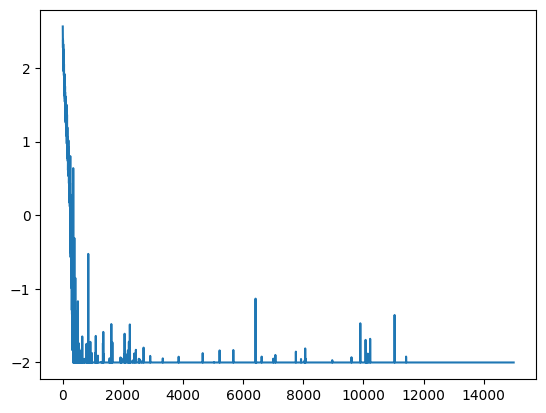

In [ ]:
plt.plot(loss_dec)

In [ ]:
!zip plotsfinal.zip plots/*